In [166]:
# ScraperScatter V5.1.0 by Josh Ward, 2026
# FULL DEMO AT BOTTOM

# Given an image, blend mode, and some extra parameters,
# stores multiple images in a file with same name as blend mode that,
# when combined, recreate original image

In [167]:
import numpy as np
import glob
from   PIL import Image
import matplotlib.pyplot as plt
import os, shutil

In [168]:
# used mainly to clear a file of the last
# batch of images for a new batch to replace it,
# hence the clause to only delete images

def clear_folder(folder):
    for filename in os.listdir(folder):
        if filename[-4:] not in ('.png','.jpg'):
            continue
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

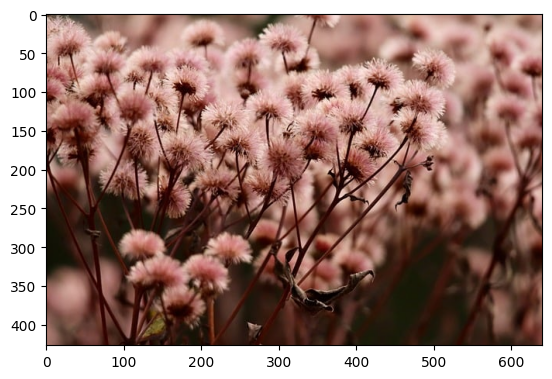

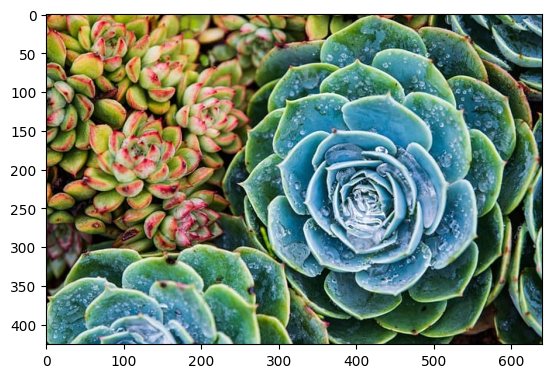

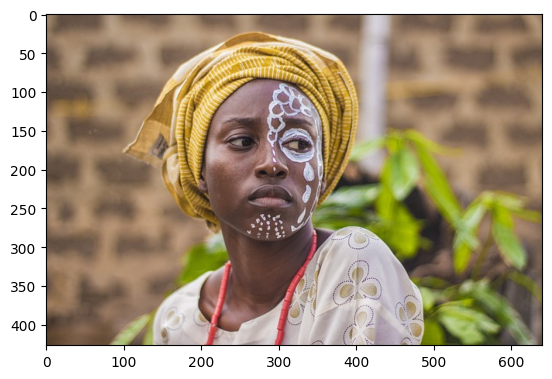

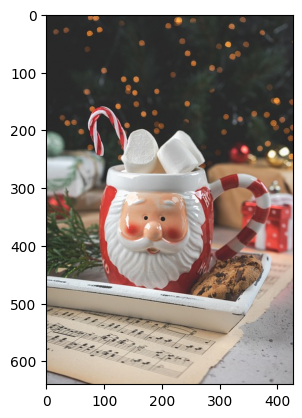

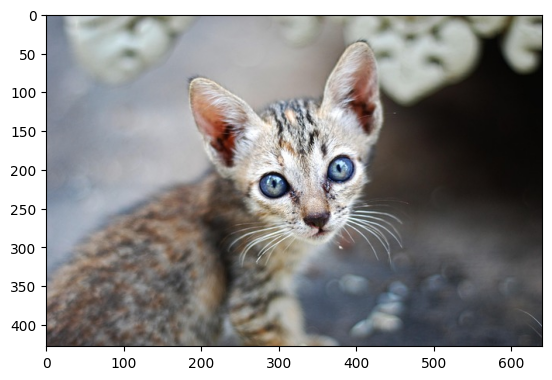

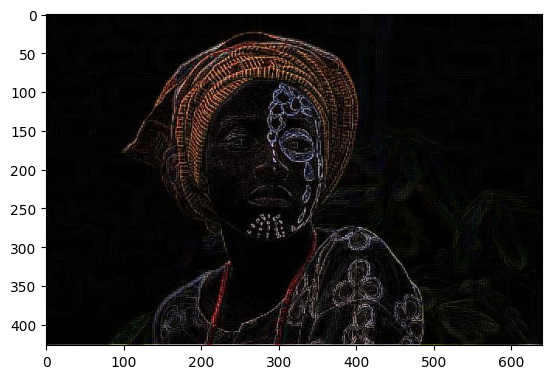

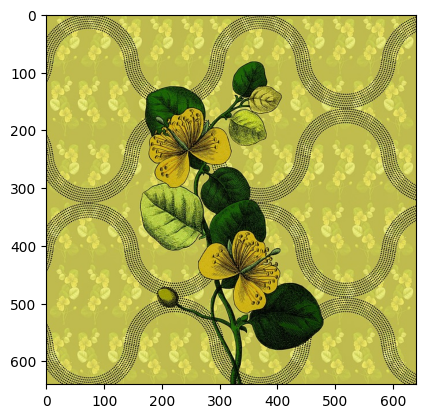

In [169]:
# gathering demo images

images = []

for filename in glob.glob('demo images/*.jpg'): #assuming gif
    im = Image.open(filename)
    im = np.array(im).astype(np.float32) / 255
    images.append(im)

    plt.imshow(im)
    plt.show()

In [170]:
# pixellates an image, returning a much smaller size image
# used for generating target LOD groups for the system.
# accepts depth for pixellation (depth of n = 2^n by 2^n pixel result)
# accepts pixellation method for usage with different blend modes

def pixellate_at_depth(image, depth=1, method = 'normal'):
    d = int(2 ** depth)
    w, h, c = image.shape

    pixel_map = image.reshape(d, w//d, d, h//d, c)
    pixel_map = pixel_map.transpose(0,2,1,3,4)

    if method == 'normal':
        pixel_map = np.average(pixel_map, axis = (2,3))
    elif method in ('multiply', 'darken'):
        pixel_map = np.max(pixel_map, axis = (2,3))
    elif method in ('screen', 'lighten', 'pluslighter'):
        pixel_map = np.min(pixel_map, axis = (2,3))
    
    return pixel_map

In [171]:
# pads an image with zeros to be a square that is a power of 2
# in both width and height, making it much easier to generate LOD groups.
# at the end, the zeros are clipped from each LOD layer

def get_padded_image(image):

    w, h, c = image.shape

    next_power_of_2 = int(2**np.ceil(np.log2(max(list(image.shape)[:2]))))
    padded_image = np.zeros((next_power_of_2, next_power_of_2, 3))
    padded_image[:w, :h] = image

    return padded_image

In [172]:
# Given a square target image and the current smaller image produced
# by all previous layers generated so far, this generates the next layer
# (assuming normal blend mode is being used)
# and the new current smaller image, with a bit more detail

# extra comments have been placed in this function that are mostly
# the same as the other blend-mode layer-extraction functions.
# for purposes of brevity, these other functions have most comments omitted.

def get_next_layer_normal(image, current_map, last_depth, display_process=False):
    # current map is only used for making these images
    # it is discarded afterwards.

    # say the image is 1024
    # and the current map is stage 1, (2*2)
    # this is log2(512), or 9
    # subtract it from the max depth, 2*10,
    # and you get 1, the current stage
    # now add 1, and done!

    w,h,c = image.shape

    # used to have to calculate depth manually
    # this_depth = int(
    #     np.log2(
    #         w
    # ) - np.log2(
    #         h / current_map.shape[0]
    #     )
    # ) + 1

    this_depth = last_depth + 1

    if display_process:
        print("Working on stage ", this_depth)

    # We need two maps: one of how the image
    # should look at this pixellation depth,
    target_map = pixellate_at_depth(image, this_depth)

    # and one of how it currently looks at this depth,
    # made by expanding the old map by 2
    current_map = np.repeat(current_map, 2, axis=0)
    current_map = np.repeat(current_map, 2, axis=1)

    # This will be a bit higher res than the old map
    if display_process:
        plt.imshow(target_map)
        plt.show()

    # this is how the current map needs to change, you'll change by
    # a multiple of this and calculate the opacity to match
    goal_changes = target_map - current_map

    # now if we make the new image the goal image,
    # fully opaque, that would work,
    # but provide no encryption whatsoever

    # how far past the target map we can go, to get the average
    # from both sides
    max_addition = np.clip(target_map + goal_changes * 1000, 0, 1)
    # this results in 0s and 1s all across the board,
    # we just use it to get the direction that each change sends
    # you in

    # subtracting gets the maximum change in each direction
    max_addition -= target_map
    # dividing converts into percentage of changes that are allowed
    max_multiplication = max_addition / (goal_changes + .00001)
    # note that this is w,h,1 in terms of dimensions, 1 channel, not 3.
    max_multiplication = np.clip(np.min(np.abs(max_addition), -1, keepdims = True), 0, 1)

    new_image = (target_map + (max_multiplication * goal_changes))# what is for what?

    new_image = np.concatenate((new_image, 1 / (max_multiplication+1)), axis = -1)
    alpha_channel = np.expand_dims(np.array(new_image[:,:,3]), axis = -1)
    current_map = current_map * (1-alpha_channel) + np.array(new_image[:,:,:3]) * alpha_channel

    new_image = np.repeat(new_image, w//new_image.shape[0], axis=0)
    new_image = np.repeat(new_image, h//new_image.shape[1], axis=1)

    # export expanded current map and this image
    return current_map, new_image



In [173]:
# Given a square target image and the current smaller image produced
# by all previous layers generated so far, this generates the next layer
# (assuming multiply blend mode is being used)
# and the new current smaller image, with a bit more detail

def get_next_layer_multiply(image, current_map, last_depth, display_process=False):
    w,h,c = image.shape

    this_depth = last_depth + 1

    if display_process:
        print("Working on stage ", this_depth)

    target_map = pixellate_at_depth(image, this_depth, method = 'multiply')

    current_map = np.repeat(current_map, 2, axis=0)
    current_map = np.repeat(current_map, 2, axis=1)

    new_image = (target_map / (current_map+.001))
    current_map = current_map * new_image

    new_image = np.clip(new_image, 0, 1)

    new_image = np.repeat(new_image, w//new_image.shape[0], axis=0)
    new_image = np.repeat(new_image, h//new_image.shape[1], axis=1)

    # export expanded current map and this image
    return current_map, new_image



In [174]:
# Given a square target image and the current smaller image produced
# by all previous layers generated so far, this generates the next layer
# (assuming screen blend mode is being used)
# and the new current smaller image, with a bit more detail

def get_next_layer_screen(image, current_map, last_depth, display_process=False):
    w,h,c = image.shape

    this_depth = last_depth + 1

    if display_process:
        print("Working on stage ", this_depth)

    target_map = pixellate_at_depth(image, this_depth, method = 'screen')

    current_map = np.repeat(current_map, 2, axis=0)
    current_map = np.repeat(current_map, 2, axis=1)

    new_image = 1 - ((1-target_map) / ((1-current_map)+.001))
    current_map = 1 - (1-current_map)*(1-new_image)

    new_image = np.clip(new_image, 0, 1)

    new_image = np.repeat(new_image, w//new_image.shape[0], axis=0)
    new_image = np.repeat(new_image, h//new_image.shape[1], axis=1)

    # export expanded current map and this image
    return current_map, new_image



In [175]:
# Given a square target image and the current smaller image produced
# by all previous layers generated so far, this generates the next layer
# (assuming lighten blend mode is being used)
# and the new current smaller image, with a bit more detail

def get_next_layer_lighten(image, current_map, last_depth, display_process=False):
    w,h,c = image.shape

    this_depth = last_depth + 1

    if display_process:
        print("Working on stage ", this_depth)

    target_map = pixellate_at_depth(image, this_depth, method = 'lighten')

    current_map = np.repeat(current_map, 2, axis=0)
    current_map = np.repeat(current_map, 2, axis=1)

    new_image = (target_map > current_map) * target_map
    current_map = np.maximum(current_map, new_image)

    new_image = np.clip(new_image, 0, 1)

    new_image = np.repeat(new_image, w//new_image.shape[0], axis=0)
    new_image = np.repeat(new_image, h//new_image.shape[1], axis=1)

    # export expanded current map and this image
    return current_map, new_image



In [176]:
# Given a square target image and the current smaller image produced
# by all previous layers generated so far, this generates the next layer
# (assuming darken blend mode is being used)
# and the new current smaller image, with a bit more detail

def get_next_layer_darken(image, current_map, last_depth, display_process=False):
    w,h,c = image.shape

    this_depth = last_depth + 1

    if display_process:
        print("Working on stage ", this_depth)

    target_map = pixellate_at_depth(image, this_depth, method = 'darken')

    current_map = np.repeat(current_map, 2, axis=0)
    current_map = np.repeat(current_map, 2, axis=1)

    new_image = ((target_map < current_map) * target_map) + ((target_map >= current_map) * 1)
    current_map = np.minimum(current_map, new_image)

    new_image = np.clip(new_image, 0, 1)

    new_image = np.repeat(new_image, w//new_image.shape[0], axis=0)
    new_image = np.repeat(new_image, h//new_image.shape[1], axis=1)

    # export expanded current map and this image
    return current_map, new_image



In [177]:
# Given a square target image and the current smaller image produced
# by all previous layers generated so far, this generates the next layer
# (assuming plus lighter blend mode is being used)
# and the new current smaller image, with a bit more detail

def get_next_layer_plus_lighter(image, current_map, last_depth, display_process=False):
    w,h,c = image.shape

    this_depth = last_depth + 1

    if display_process:
        print("Working on stage ", this_depth)

    target_map = pixellate_at_depth(image, this_depth, method = 'pluslighter')

    current_map = np.repeat(current_map, 2, axis=0)
    current_map = np.repeat(current_map, 2, axis=1)

    new_image = target_map - current_map
    current_map = current_map + new_image

    new_image = np.clip(new_image, 0, 1)

    new_image = np.repeat(new_image, w//new_image.shape[0], axis=0)
    new_image = np.repeat(new_image, h//new_image.shape[1], axis=1)

    # export expanded current map and this image
    return current_map, new_image



In [178]:
# given image, method, and some other parameters,
# applies the whole pipeline, padding and extracting layers.
# it stores all layers (de-padded) in a folder with the same name
# as the blend mode. it returns the base image, low res, and a list 
# of all the layers it has generated.

def generate_component_images(image, starting_depth=1, method='normal', display_process=True):

    clear_folder(method)
    
    # pad to power of 2 for easy subdivision
    padded_image = get_padded_image(image)
    w,h,c = padded_image.shape

    # base is the starting layer, currently very shrunken
    base = pixellate_at_depth(padded_image, starting_depth, method)

    # copy it into current_map for use in the pipeline
    current_map = np.array(base)

    # how many times to do a layer pass
    # basically, get the difference between
    # base and the full padded image
    # and use log2 to tell how many 
    # times to double the size.
    num_layers = int(
        np.log2(
            h / base.shape[0]
        )
    )
    # for example, if h / base.shape[0] is 1,
    # meaning they're the same, log2 is zero,
    # and no layer passes are done

    layer_images = []

    # MAIN PIPELINE LOOP
    
    for i in range(num_layers):

        current_depth = starting_depth + i

        if method == 'normal':
            current_map, new_image = get_next_layer_normal(padded_image, current_map, current_depth)
        elif method == 'multiply':
            current_map, new_image = get_next_layer_multiply(padded_image, current_map, current_depth)
        elif method == 'screen':
            current_map, new_image = get_next_layer_screen(padded_image, current_map, current_depth)
        elif method == 'lighten':
            current_map, new_image = get_next_layer_lighten(padded_image, current_map, current_depth)
        elif method == 'darken':
            current_map, new_image = get_next_layer_darken(padded_image, current_map, current_depth)
        elif method == 'pluslighter':
            current_map, new_image = get_next_layer_plus_lighter(padded_image, current_map, current_depth)

        if display_process:
            plt.title("Current Reconstructed image")
            plt.imshow(current_map)
            plt.show()

            plt.title("Current Encryption layer")
            plt.imshow(new_image)
            plt.show()

        layer_images.append(new_image)

    #POST PROCESSING AND EXPORT

    # now make the base image the proper size
    base = np.repeat(base, w//base.shape[0], axis=0)
    base = np.repeat(base, h//base.shape[1], axis=1)


    # clip all images x+y, don't clip channels, and save
    base = base[:image.shape[0], :image.shape[1]]
    base_im = Image.fromarray((base*255).astype(np.uint8))
    base_im.save(f"{method}/base.jpg")

    for i, layer_image in enumerate(layer_images):
        layer_images[i] = layer_image[:image.shape[0], :image.shape[1]]

        im = Image.fromarray((layer_images[i]*255).astype(np.uint8))
        if layer_images[i].shape[-1] == 4:
            im.save(f"{method}/image_{i}.png")
        else:
            im.save(f"{method}/image_{i}.jpg")

    return base, layer_images

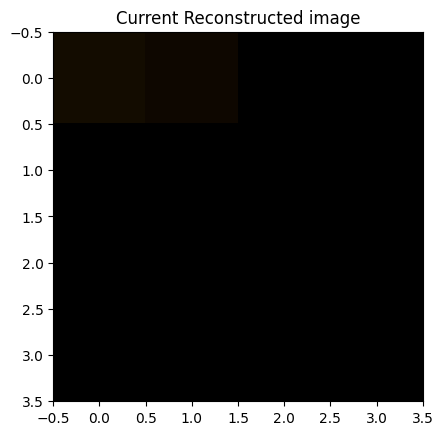

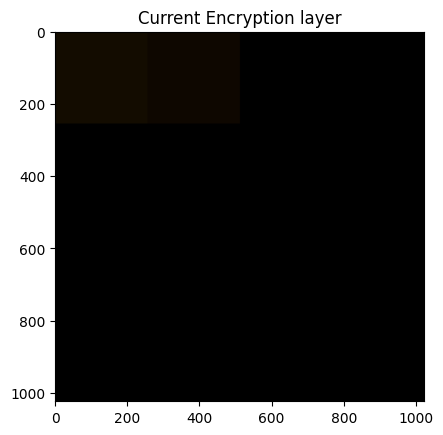

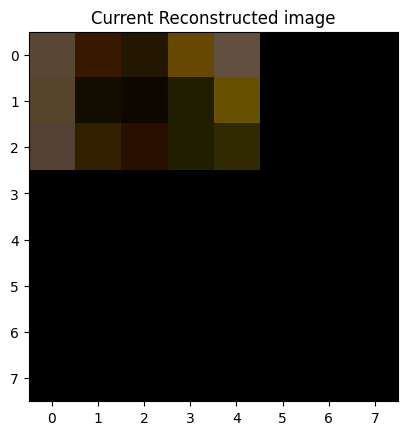

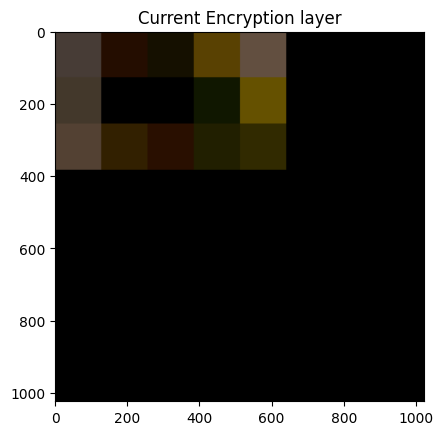

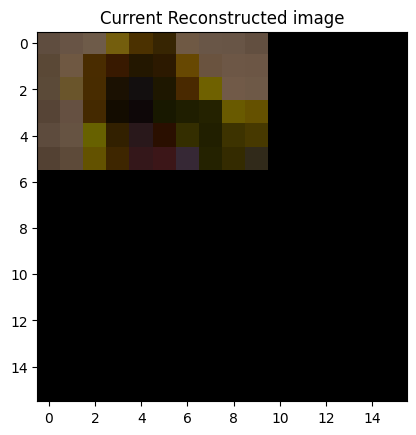

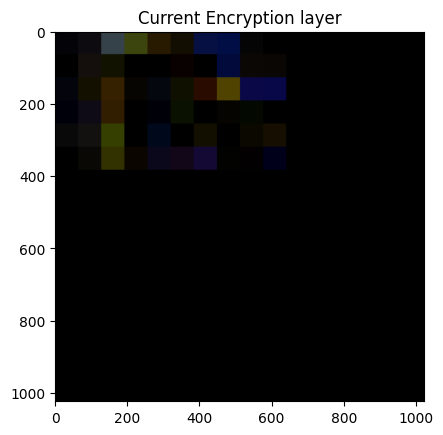

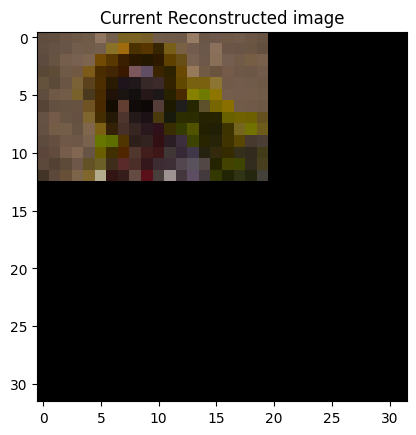

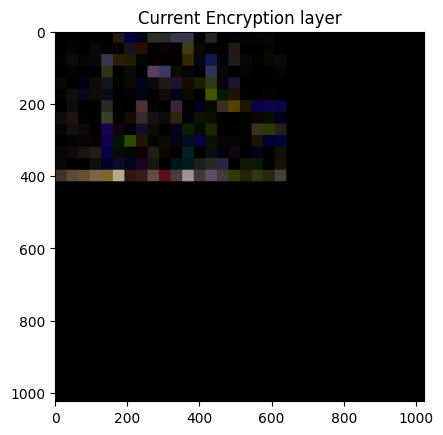

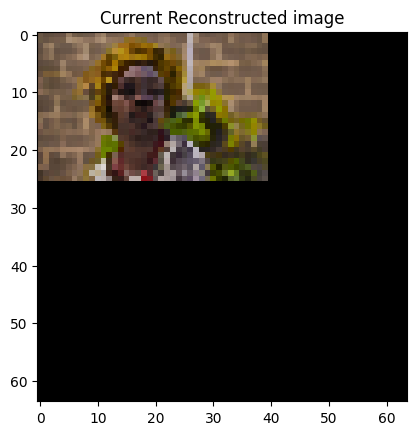

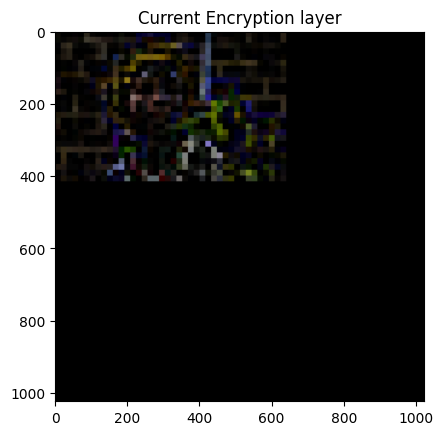

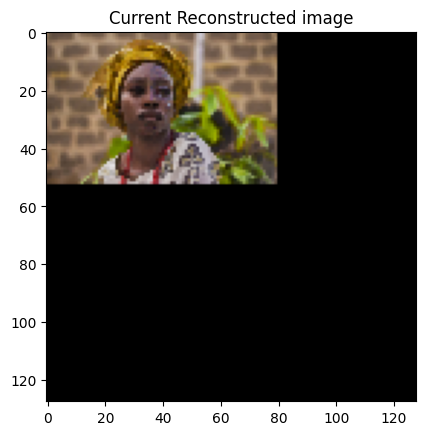

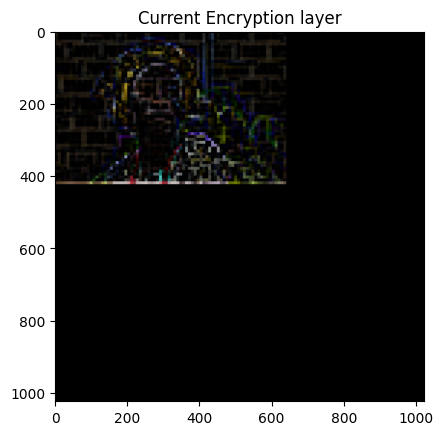

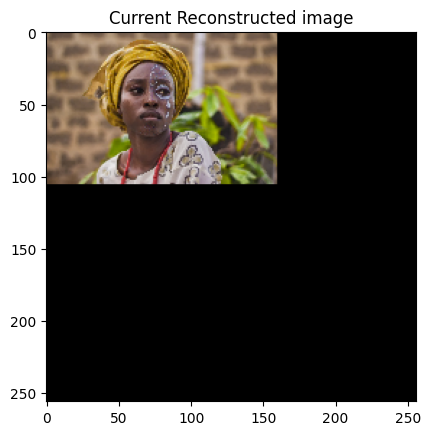

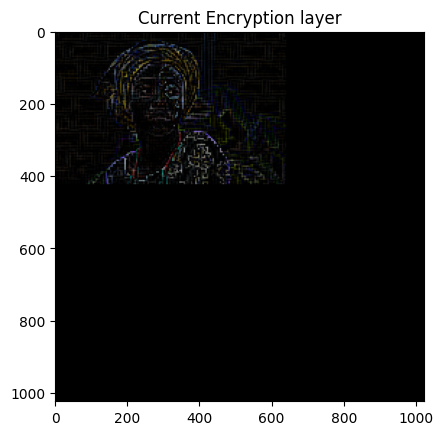

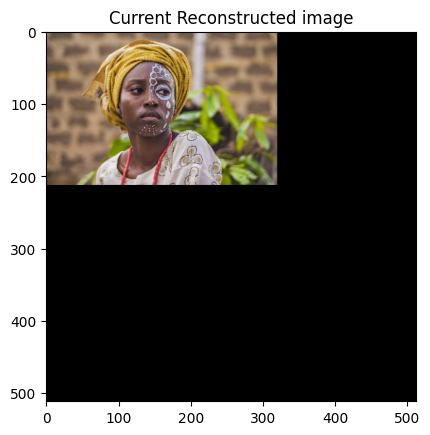

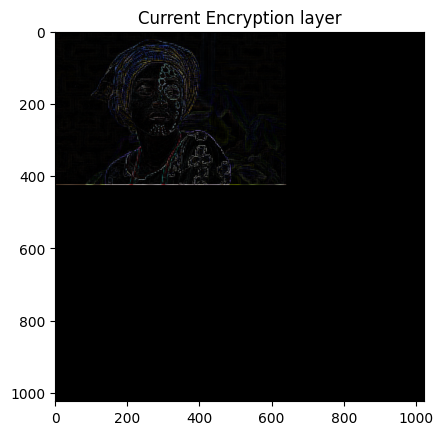

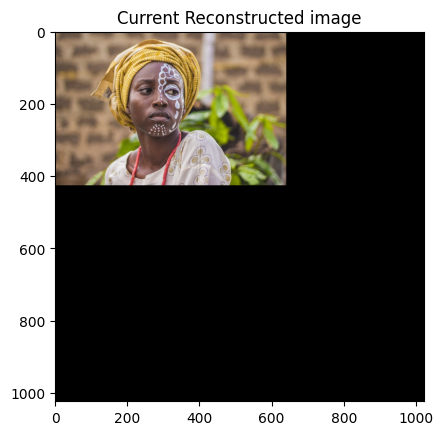

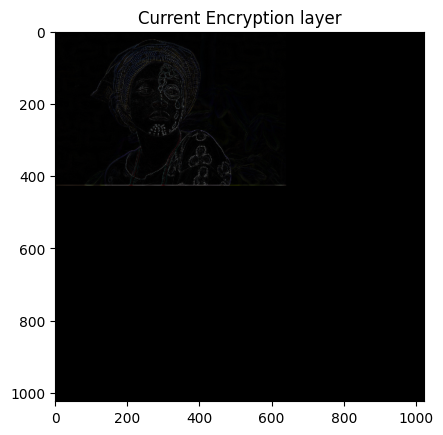

(array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]),
 [array([[[0.07450981, 0.04705882, 0.        ],
       

In [ ]:
# Current available methods:
# normal < not that good scattering
# lighten < not that good either.
# darken < a bit better
# pluslighter < later layers are faded
# multiply < much better
# screen < best so far

# run code, appreciate images below, and then
# open index.html from the correctly named folder
# in your browser to see results.

generate_component_images(images[2], 1, method = 'pluslighter')